In [1]:
planta = 21
print("Planta a Analizar: ", planta)

Planta a Analizar:  21


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: center; text-align: center; justify-content: center; } </style> """))

In [3]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [4]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos.loc['2020-01-01 00:00:00':]

# datos = datos.drop(datos.index[-24:])

In [5]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314','GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [6]:
n_periods = 5*24
columna = columns[planta-1]
columna

'GICIS321'

In [7]:
df = datos[['hora',columna]]
df[columna] = (df[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
df = df.dropna()
df.head()

,hora,GICIS321
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0


In [8]:
df2 = df.drop(['hora'], axis=1)
df2

,GICIS321
fecha_hora,
2020-01-01 00:00:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0
...,...
2020-03-09 19:00:00,0.0
2020-03-09 20:00:00,0.0
2020-03-09 21:00:00,0.0


***

In [9]:
#Seleccion de y_train y y_test
  
n = 1 #numero de dias a simular
test = (df.iloc[-(1*24):,:])   # INFO DE TEST (n DIAS)
train = df.drop(df.index[:(1*24)]) # QUITANDO TEST PARA TRAIN

In [10]:
train

,hora,GICIS321
fecha_hora,,
2020-01-02 00:00:00,1,0.0
2020-01-02 01:00:00,2,0.0
2020-01-02 02:00:00,3,0.0
2020-01-02 03:00:00,4,0.0
2020-01-02 04:00:00,5,0.0
...,...,...
2020-03-09 19:00:00,20,0.0
2020-03-09 20:00:00,21,0.0
2020-03-09 21:00:00,22,0.0


In [11]:
train.iloc[6]

hora        7.0
GICIS321    0.0
Name: 2020-01-02 06:00:00, dtype: float64

In [12]:
test

,hora,GICIS321
fecha_hora,,
2020-03-09 00:00:00,1,0.0
2020-03-09 01:00:00,2,0.0
2020-03-09 02:00:00,3,0.0
2020-03-09 03:00:00,4,0.0
2020-03-09 04:00:00,5,0.0
2020-03-09 05:00:00,6,0.0
2020-03-09 06:00:00,7,0.0
2020-03-09 07:00:00,8,17740.0
2020-03-09 08:00:00,9,44948.0


In [13]:
xhr = pd.DataFrame()
for i in range(0,24):
    hrs = [train.iloc[j][1] for j in range(0,len(train)) if train.iloc[j][0] == i+1 ] #pd.Series()
    xhr['Hora '+str(i+1)] = hrs
xhr = xhr.drop([xhr.index[-1]])
xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3040.0,8344.0,...,121483.0,113987.0,118179.0,15236.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1698.0,85527.0,134170.0,...,116874.0,116946.0,113654.0,20966.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993.0,85591.0,124917.0,...,129293.0,131060.0,112783.0,24182.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2037.0,81153.0,127014.0,...,117797.0,123404.0,102896.0,25234.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2388.0,87343.0,127128.0,...,112916.0,110042.0,88569.0,23601.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4477.0,25617.0,65814.0,...,134124.0,98073.0,44736.0,54614.0,6687.0,0.0,0.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6388.0,46982.0,122530.0,...,126111.0,110941.0,65166.0,27354.0,7127.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5389.0,35185.0,136518.0,...,99011.0,111358.0,78705.0,33460.0,2821.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6607.0,27932.0,91990.0,...,128377.0,114482.0,107119.0,54844.0,2056.0,0.0,0.0,0.0,0.0,0.0


In [14]:
train = train.drop(['hora'], axis=1)
test = test.drop(['hora'], axis=1)

*** 
# Modelo ARIMA

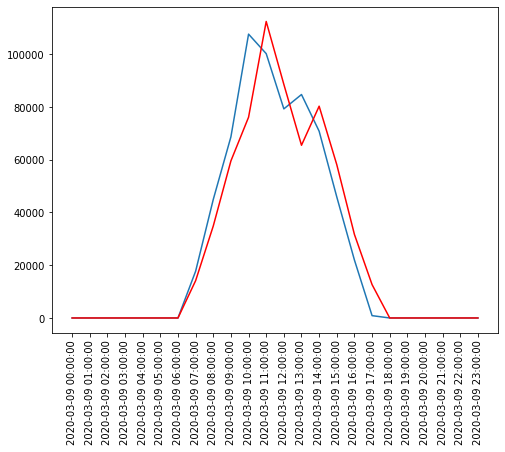

In [15]:
history = [x for x in train.values]
predictions = []

for t in range(0,24):
    model = ARIMA(history, order=(8,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.values[t]
    history.append(obs)

for i in range(0,len(test)): # SUPUESTO 1: SI NO HUBO PRODUCCIÓN UN DÍA ANTES, NO HABRÁ ESE DÍA. 
    if test.iloc[i].values == 0:
        predictions[i] = 0
    if predictions[i] < 0:
        predictions[i] = 0
        
# plot
plt.subplots(figsize=(8,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [16]:
fvst = pd.DataFrame()
fvst['real'] = test[columna].values.flatten()
fvst['forecasts'] = 0
for i in range(len(fvst)):
    if predictions[i] == 0:
        fvst['forecasts'][i] = predictions[i]
    else:
        fvst['forecasts'][i] = predictions[i].item()
fvst['error'] = 0

for i in range(len(fvst)):
    fvst['error'][i] = np.abs((fvst['forecasts'][i]- fvst['real'][i])/(fvst['real'][i]))

mea = np.mean(fvst.iloc[7:19,2])
mea

1.4086354604474651

In [17]:
fvst = fvst.fillna(0)
print(np.mean(fvst.error))
fvst

0.6456245860384215


,real,forecasts,error
0,0.0,0,0.000000
1,0.0,0,0.000000
2,0.0,0,0.000000
3,0.0,0,0.000000
4,0.0,0,0.000000
5,0.0,0,0.000000
6,0.0,0,0.000000
7,17740.0,14145,0.202649
8,44948.0,34884,0.223903
9,68701.0,59569,0.132924


In [18]:
np.abs((sum(fvst['forecasts']) - sum(fvst['real']))/sum(fvst['real']))

0.013798327588566878

# Tomando promedios anteriores:

# Cambiando 7 8 y 9:

In [19]:
fvst.iloc[7,1]

14145

In [20]:
xhr['Hora 8'][-7:]

60    19019.0
61    10249.0
62     4477.0
63     6388.0
64     5389.0
65     6607.0
66     1814.0
Name: Hora 8, dtype: float64

In [21]:
fvst.iloc[7,1] = np.mean(xhr['Hora 8'][-7:])
fvst.iloc[8,1] = np.mean(xhr['Hora 9'][-7:])
fvst.iloc[9,1] = np.mean(xhr['Hora 10'][-7:])

for i in range(len(fvst)):
    fvst['error'][i] = np.abs((fvst['forecasts'][i]- fvst['real'][i])/(fvst['real'][i]))

fvst = fvst.fillna(0)
fvst

,real,forecasts,error
0,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000
5,0.0,0.000000,0.000000
6,0.0,0.000000,0.000000
7,17740.0,7706.142857,0.565606
8,44948.0,45765.571429,0.018189
9,68701.0,94431.714286,0.374532


In [22]:
mea = np.mean(fvst.iloc[7:19,2])
mea

1.3244867669421567

In [23]:
np.abs((sum(fvst['forecasts']) - sum(fvst['real']))/sum(fvst['real']))

0.04733899395777385

## Cambiando Hora 17, 18 y 19:

In [24]:
fvst.iloc[16,1] = np.mean(xhr['Hora 17'][-7:])
fvst.iloc[17,1] = np.mean(xhr['Hora 18'][-7:])
fvst.iloc[18,1] = np.mean(xhr['Hora 19'][-7:])

for i in range(len(fvst)):
    fvst['error'][i] = np.abs((fvst['forecasts'][i]- fvst['real'][i])/(fvst['real'][i]))

fvst = fvst.fillna(0)
fvst

,real,forecasts,error
0,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000
5,0.0,0.000000,0.000000
6,0.0,0.000000,0.000000
7,17740.0,7706.142857,0.565606
8,44948.0,45765.571429,0.018189
9,68701.0,94431.714286,0.374532


In [25]:
mea = np.mean(fvst.iloc[7:19,2])
mea

inf

In [26]:
np.abs((sum(fvst['forecasts']) - sum(fvst['real']))/sum(fvst['real']))

0.1799517724041448